# 🏦 MAEC FinBERT Financial Risk Prediction Pipeline

**Pipeline:**
```
MAEC folders → Metadata → CAR (yfinance) → FinBERT embeddings → Feature engineering → ML models → Evaluation
```

**Enable GPU:** Runtime → Change runtime type → T4 GPU (needed for FinBERT)

## 📦 CELL 1 — Install Dependencies

In [ ]:
%%capture
!pip install transformers torch yfinance pandas numpy scikit-learn xgboost tqdm matplotlib seaborn

## 📁 CELL 2 — Imports & Config

In [10]:
import os, re, glob, warnings
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

import torch
from transformers import AutoTokenizer, AutoModel

import yfinance as yf

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, f1_score, roc_auc_score, classification_report
)
from xgboost import XGBRegressor, XGBClassifier

# ── CONFIG ─────────────────────────────────────────────────────────────────
MAEC_ROOT      = 'E:/Prem Lehar/Scripts/CURSOR scripts/ADNI_MRI/v9_ADNI_MRI_700_Without_Resampling_3DCNN_MedicalNet/ATS_PROJECT_CODE/data/MAEC-A-Multimodal-Aligned-Earnings-Conference-Call-Dataset-for-Financial-Risk-Prediction-master'   # 📂 Change this to your dataset path
OUTPUT_DIR     = 'E:/Prem Lehar/Scripts/CURSOR scripts/ADNI_MRI/v9_ADNI_MRI_700_Without_Resampling_3DCNN_MedicalNet/ATS_PROJECT_CODE/outputs_new_one_ats_project'
DEVICE         = 'cuda' if torch.cuda.is_available() else 'cpu'
TRAIN_END_YEAR = 2018   # time-based split
TEST_START_YEAR= 2019

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f'Device: {DEVICE}')
print(f'MAEC root: {MAEC_ROOT}')
print('✅ Imports complete')

Device: cuda
MAEC root: E:/Prem Lehar/Scripts/CURSOR scripts/ADNI_MRI/v9_ADNI_MRI_700_Without_Resampling_3DCNN_MedicalNet/ATS_PROJECT_CODE/data/MAEC-A-Multimodal-Aligned-Earnings-Conference-Call-Dataset-for-Financial-Risk-Prediction-master
✅ Imports complete


In [11]:
import os

MAEC_ROOT = os.path.join(MAEC_ROOT, 'MAEC_Dataset')

# Verify
folders = [d for d in os.listdir(MAEC_ROOT) if os.path.isdir(os.path.join(MAEC_ROOT, d))]
print(f"✅ Fixed! Found {len(folders)} folders")
print(f"Sample: {folders[:5]}")

✅ Fixed! Found 239 folders
Sample: ['20150302_TG', '20150303_NX', '20150306_FL', '20150401_MU', '20150421_RF']


In [12]:
# ── CELL 4 (FIXED) — Full Build ────────────────────────────────────────────

def parse_folder_name(folder_name):
    """
    Handles formats like:
      20150302_MU
      20150302_TG_NX
      2015-03-02_MU   (just in case)
    Returns (date as dd/mm/yyyy string, ticker)
    """
    # Normalize: remove dashes from date part if present
    folder_name = folder_name.strip()
    parts = folder_name.split('_')
    
    if len(parts) < 2:
        return None, None
    
    raw_date = parts[0].replace('-', '')  # handle 2015-03-02 or 20150302
    ticker   = parts[-1].upper()          # last segment = ticker
    
    # Validate date is 8 digits
    if not raw_date.isdigit() or len(raw_date) != 8:
        return None, None
    
    try:
        # raw_date is YYYYMMDD → parse and reformat to dd/mm/yyyy
        dt   = datetime.strptime(raw_date, '%Y%m%d')
        date = dt.strftime('%d/%m/%Y')
    except ValueError:
        return None, None
    
    return date, ticker


def read_transcript(folder_path):
    """
    Reads the first .txt file found in the folder.
    Tries common names first, then falls back to any .txt.
    """
    candidates = ['text.txt', 'transcript.txt', 'call.txt', 'body.txt', 'content.txt']
    for c in candidates:
        fp = os.path.join(folder_path, c)
        if os.path.exists(fp):
            with open(fp, 'r', encoding='utf-8', errors='ignore') as f:
                return f.read().strip()
    
    # Fallback: grab any .txt file
    txt_files = glob.glob(os.path.join(folder_path, '*.txt'))
    if txt_files:
        with open(txt_files[0], 'r', encoding='utf-8', errors='ignore') as f:
            return f.read().strip()
    
    return None


# ── Main loop ──────────────────────────────────────────────────────────────
records       = []
skipped_parse = []
skipped_txt   = []

folders = sorted([
    d for d in os.listdir(MAEC_ROOT)
    if os.path.isdir(os.path.join(MAEC_ROOT, d))
])

print(f"Found {len(folders)} folders. Parsing...")

for folder in tqdm(folders, desc='Parsing folders'):
    date, ticker = parse_folder_name(folder)
    
    if date is None:
        skipped_parse.append(folder)
        continue
    
    transcript = read_transcript(os.path.join(MAEC_ROOT, folder))
    
    if transcript is None or len(transcript) < 50:
        skipped_txt.append(folder)
        continue
    
    records.append({
        'folder'    : folder,
        'ticker'    : ticker,
        'date'      : date,
        'transcript': transcript
    })

# ── Report ─────────────────────────────────────────────────────────────────
print(f"\n✅ Parsed successfully : {len(records)}")
print(f"❌ Skipped (bad name)  : {len(skipped_parse)}  e.g. {skipped_parse[:3]}")
print(f"❌ Skipped (no .txt)   : {len(skipped_txt)}   e.g. {skipped_txt[:3]}")

if len(records) == 0:
    print("\n⚠️  records is EMPTY. Check the two skip lists above.")
    print("Most likely cause: .txt file has a different name inside the folder.")
    print("Run this to inspect one folder:")
    print(f"  print(os.listdir(os.path.join(MAEC_ROOT, folders[0])))")
else:
    df_raw = pd.DataFrame(records)
    # date is already dd/mm/yyyy string — convert to datetime
    df_raw['date'] = pd.to_datetime(df_raw['date'], format='%d/%m/%Y')
    df_raw.to_csv(f'{OUTPUT_DIR}/events_raw.csv', index=False)

    print(f'\n✅ events_raw.csv  →  {len(df_raw)} events')
    print(df_raw[['ticker', 'date', 'folder']].head(10))
    print(f"\nDate range : {df_raw['date'].min().date()} → {df_raw['date'].max().date()}")
    print(f"Unique tickers: {df_raw['ticker'].nunique()}")

Found 239 folders. Parsing...


Parsing folders: 100%|██████████| 239/239 [00:00<00:00, 10129.63it/s]


✅ Parsed successfully : 238
❌ Skipped (bad name)  : 0  e.g. []
❌ Skipped (no .txt)   : 1   e.g. ['20151105_HE']

✅ events_raw.csv  →  238 events
  ticker       date       folder
0     TG 2015-03-02  20150302_TG
1     NX 2015-03-03  20150303_NX
2     FL 2015-03-06  20150306_FL
3     MU 2015-04-01  20150401_MU
4     RF 2015-04-21  20150421_RF
5     AN 2015-04-22  20150422_AN
6     BA 2015-04-22  20150422_BA
7      R 2015-04-22   20150422_R
8     HF 2015-04-29  20150429_HF
9     LL 2015-04-29  20150429_LL

Date range : 2015-03-02 → 2018-05-08
Unique tickers: 88


## 📈 CELL 5 — STEP 2: Compute CAR + Financial Features (events_with_finance.csv)

> This cell downloads price data from yfinance. It may take a few minutes for 240 tickers.

In [13]:
# ── Load raw events (skip if running from scratch) ─────────────────────────
if 'df_raw' not in dir():
    df_raw = pd.read_csv(f'{OUTPUT_DIR}/events_raw.csv', parse_dates=['date'])

# ── Helper functions ───────────────────────────────────────────────────────

def get_prices(ticker, date, window=10):
    """
    Download adjusted close + volume around event date.
    Returns DataFrame with columns: adj_close, volume.
    """
    start = (date - timedelta(days=window*3)).strftime('%Y-%m-%d')
    end   = (date + timedelta(days=window*3)).strftime('%Y-%m-%d')
    try:
        data = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=True)
        if data.empty:
            return None
        data.index = pd.to_datetime(data.index)
        return data[['Close', 'Volume']].rename(columns={'Close':'adj_close','Volume':'volume'})
    except Exception:
        return None


def get_market(date, window=10):
    start = (date - timedelta(days=window*3)).strftime('%Y-%m-%d')
    end   = (date + timedelta(days=window*3)).strftime('%Y-%m-%d')
    try:
        data = yf.download('^GSPC', start=start, end=end, progress=False, auto_adjust=True)
        if data.empty:
            return None
        data.index = pd.to_datetime(data.index)
        return data[['Close']].rename(columns={'Close':'market_close'})
    except Exception:
        return None


def compute_car(ticker_prices, market_prices, event_date):
    features = {}

    # ── Flatten MultiIndex columns if yfinance returns them ───────────────
    def flatten_df(df):
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = [col[0] for col in df.columns]
        return df

    ticker_prices = flatten_df(ticker_prices.copy())
    market_prices = flatten_df(market_prices.copy())

    # ── Ensure index is plain DatetimeIndex (drop ticker level if present) ─
    ticker_prices.index = pd.to_datetime(ticker_prices.index.get_level_values(0))
    market_prices.index = pd.to_datetime(market_prices.index.get_level_values(0))

    # ── Remove duplicate dates (keep last) ────────────────────────────────
    ticker_prices = ticker_prices[~ticker_prices.index.duplicated(keep='last')]
    market_prices = market_prices[~market_prices.index.duplicated(keep='last')]

    # ── Merge on date ──────────────────────────────────────────────────────
    df = ticker_prices.join(market_prices, how='inner')
    if len(df) < 5:
        return None

    # Log returns
    df['r_stock']  = np.log(df['adj_close'] / df['adj_close'].shift(1))
    df['r_market'] = np.log(df['market_close'] / df['market_close'].shift(1))
    df = df.dropna()

    if len(df) < 5:
        return None

    # Find event date (or next available trading day)
    trading_days = df.index.sort_values()
    future_days  = trading_days[trading_days >= pd.Timestamp(event_date)]
    if len(future_days) == 0:
        return None
    t0  = future_days[0]
    idx = trading_days.get_loc(t0)  # guaranteed integer now (no duplicates)

    # Estimation window: [-35, -5] for beta
    est_start  = max(0, idx - 35)
    est_end    = max(0, idx - 5)
    est_window = df.iloc[est_start:est_end]

    if len(est_window) < 10:
        beta, alpha = 1.0, 0.0
    else:
        from sklearn.linear_model import LinearRegression as LR
        X  = est_window['r_market'].values.reshape(-1, 1)
        y  = est_window['r_stock'].values
        lr = LR().fit(X, y)
        beta  = float(lr.coef_[0])
        alpha = float(lr.intercept_)

    # Abnormal return at a given position
    def get_ar(day_idx):
        if day_idx < 0 or day_idx >= len(df):
            return np.nan
        r_s = float(df['r_stock'].iloc[day_idx])
        r_m = float(df['r_market'].iloc[day_idx])
        return r_s - (alpha + beta * r_m)

    ar0 = get_ar(idx)
    ar1 = get_ar(idx + 1)

    # Both must be valid scalars
    if np.isnan(ar0) or np.isnan(ar1):
        return None

    features['CAR'] = ar0 + ar1
    features['AR0'] = ar0
    features['AR1'] = ar1

    # Returns r[-5 .. +5]
    for offset in range(-5, 6):
        features[f'r_{offset:+d}'] = get_ar(idx + offset)

    # Pre-event volatility
    features['pre_volatility'] = float(est_window['r_stock'].std()) if len(est_window) > 2 else np.nan

    # Volume ratio
    pre_vol_window = df.iloc[max(0, idx - 5):idx]['volume']
    event_vol      = float(df['volume'].iloc[idx]) if idx < len(df) else np.nan
    avg_pre_vol    = float(pre_vol_window.mean()) if len(pre_vol_window) > 0 else np.nan
    features['volume_ratio'] = event_vol / avg_pre_vol if (avg_pre_vol and avg_pre_vol > 0) else np.nan

    # Market return on event day
    features['market_r0'] = float(df['r_market'].iloc[idx]) if idx < len(df) else np.nan

    # Momentum [-20, -2]
    mom_start = max(0, idx - 20)
    mom_end   = max(0, idx - 1)
    features['momentum_20d'] = float(df.iloc[mom_start:mom_end]['r_stock'].sum())

    return features


# ── Main loop ──────────────────────────────────────────────────────────────
# Cache market data per date to avoid repeated downloads
market_cache = {}

fin_rows = []
failed   = 0

for _, row in tqdm(df_raw.iterrows(), total=len(df_raw), desc='Computing CAR'):
    ticker     = row['ticker']
    event_date = row['date']
    date_key   = event_date.strftime('%Y-%m')

    # Ticker prices
    prices = get_prices(ticker, event_date)
    if prices is None:
        failed += 1
        continue

    # Market prices (cache by month)
    if date_key not in market_cache:
        market_cache[date_key] = get_market(event_date)
    market = market_cache[date_key]
    if market is None:
        failed += 1
        continue

    car_features = compute_car(prices, market, event_date)
    if car_features is None:
        failed += 1
        continue

    combined = {
        'folder'    : row['folder'],
        'ticker'    : ticker,
        'date'      : event_date,
        'transcript': row['transcript'],
        **car_features
    }
    fin_rows.append(combined)


df_finance = pd.DataFrame(fin_rows)
df_finance.to_csv(f'{OUTPUT_DIR}/events_with_finance.csv', index=False)

print(f'\n✅ events_with_finance.csv  →  {len(df_finance)} events  ({failed} failed/skipped)')
print(f"CAR stats:\n{df_finance['CAR'].describe()}")
print(f"\nColumns: {list(df_finance.columns)}")

Computing CAR:   1%|          | 2/238 [00:06<12:21,  3.14s/it]$FL: possibly delisted; no timezone found

1 Failed download:
['FL']: possibly delisted; no timezone found
Computing CAR:   3%|▎         | 8/238 [00:12<03:55,  1.02s/it]$HF: possibly delisted; no price data found  (1d 2015-03-30 -> 2015-05-29) (Yahoo error = "Data doesn't exist for startDate = 1427688000, endDate = 1432872000")

1 Failed download:
['HF']: possibly delisted; no price data found  (1d 2015-03-30 -> 2015-05-29) (Yahoo error = "Data doesn't exist for startDate = 1427688000, endDate = 1432872000")
Computing CAR:   4%|▍         | 9/238 [00:13<04:03,  1.06s/it]$LL: possibly delisted; no timezone found

1 Failed download:
['LL']: possibly delisted; no timezone found
Computing CAR:   4%|▍         | 10/238 [00:14<03:29,  1.09it/s]$PX: possibly delisted; no price data found  (1d 2015-03-30 -> 2015-05-29) (Yahoo error = "Data doesn't exist for startDate = 1427688000, endDate = 1432872000")

1 Failed download:
['PX']: pos


✅ events_with_finance.csv  →  178 events  (60 failed/skipped)
CAR stats:
count    178.000000
mean       0.001810
std        0.067931
min       -0.307971
25%       -0.026590
50%       -0.001714
75%        0.030096
max        0.343910
Name: CAR, dtype: float64

Columns: ['folder', 'ticker', 'date', 'transcript', 'CAR', 'AR0', 'AR1', 'r_-5', 'r_-4', 'r_-3', 'r_-2', 'r_-1', 'r_+0', 'r_+1', 'r_+2', 'r_+3', 'r_+4', 'r_+5', 'pre_volatility', 'volume_ratio', 'market_r0', 'momentum_20d']


## 📊 CELL 6 — EDA: CAR Distribution

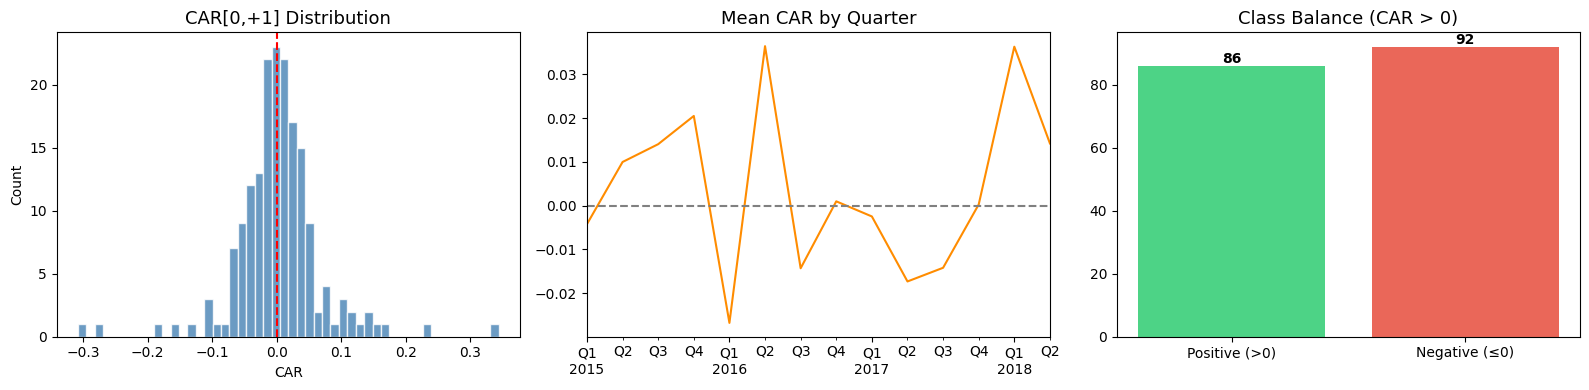

Positive CAR: 86 (48.3%)


In [14]:
if 'df_finance' not in dir():
    df_finance = pd.read_csv(f'{OUTPUT_DIR}/events_with_finance.csv', parse_dates=['date'])

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# CAR histogram
axes[0].hist(df_finance['CAR'].dropna(), bins=50, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].axvline(0, color='red', linestyle='--', linewidth=1.5)
axes[0].set_title('CAR[0,+1] Distribution', fontsize=13)
axes[0].set_xlabel('CAR')
axes[0].set_ylabel('Count')

# CAR over time
df_finance.set_index('date')['CAR'].resample('Q').mean().plot(ax=axes[1], color='darkorange')
axes[1].axhline(0, color='gray', linestyle='--')
axes[1].set_title('Mean CAR by Quarter', fontsize=13)
axes[1].set_xlabel('')

# Class balance
labels = ['Positive (>0)', 'Negative (≤0)']
counts = [(df_finance['CAR'] > 0).sum(), (df_finance['CAR'] <= 0).sum()]
axes[2].bar(labels, counts, color=['#2ecc71', '#e74c3c'], alpha=0.85)
axes[2].set_title('Class Balance (CAR > 0)', fontsize=13)
for i, v in enumerate(counts):
    axes[2].text(i, v + 1, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/car_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Positive CAR: {counts[0]} ({counts[0]/sum(counts)*100:.1f}%)")

## 🤖 CELL 7 — STEP 3: FinBERT Embedding Extraction

> ⚡ Uses GPU if available. Long transcripts are chunked into 512-token pieces and averaged.

In [15]:
# ── Load FinBERT ───────────────────────────────────────────────────────────
FINBERT_MODEL = 'ProsusAI/finbert'

print(f'Loading FinBERT on {DEVICE}...')
tokenizer = AutoTokenizer.from_pretrained(FINBERT_MODEL)
model     = AutoModel.from_pretrained(FINBERT_MODEL).to(DEVICE)
model.eval()
print('✅ FinBERT loaded')

Loading FinBERT on cuda...


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 
classifier.bias              | UNEXPECTED |  | 
classifier.weight            | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ FinBERT loaded


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [16]:
def get_finbert_embedding(text, chunk_size=512, overlap=50):
    """
    Encode long text by chunking, extracting CLS embedding per chunk,
    then mean-pooling across chunks.
    Returns numpy array of shape (768,).
    """
    # Tokenize full text
    tokens = tokenizer(
        text,
        add_special_tokens=False,
        return_tensors='pt'
    )
    input_ids      = tokens['input_ids'][0]
    attention_mask = tokens['attention_mask'][0]
    total_tokens   = len(input_ids)

    # Split into overlapping chunks of (chunk_size - 2) tokens [for CLS/SEP]
    effective = chunk_size - 2
    step      = effective - overlap
    chunk_embeddings = []

    for start in range(0, max(1, total_tokens), step):
        end        = min(start + effective, total_tokens)
        chunk_ids  = input_ids[start:end]
        chunk_mask = attention_mask[start:end]

        # Add CLS and SEP
        cls_id  = torch.tensor([tokenizer.cls_token_id])
        sep_id  = torch.tensor([tokenizer.sep_token_id])
        chunk_ids  = torch.cat([cls_id, chunk_ids, sep_id]).unsqueeze(0).to(DEVICE)
        chunk_mask = torch.cat([torch.ones(1), chunk_mask, torch.ones(1)]).unsqueeze(0).to(DEVICE)
        chunk_mask = chunk_mask.long()

        with torch.no_grad():
            outputs = model(input_ids=chunk_ids, attention_mask=chunk_mask)

        # CLS token embedding
        cls_emb = outputs.last_hidden_state[:, 0, :].squeeze(0).cpu().numpy()
        chunk_embeddings.append(cls_emb)

        if end >= total_tokens:
            break

    return np.mean(chunk_embeddings, axis=0)  # (768,)


# ── Extract embeddings ─────────────────────────────────────────────────────
if 'df_finance' not in dir():
    df_finance = pd.read_csv(f'{OUTPUT_DIR}/events_with_finance.csv', parse_dates=['date'])

EMB_BATCH = 8   # process N transcripts, then save checkpoint
emb_path  = f'{OUTPUT_DIR}/embeddings_cache.npy'
idx_path  = f'{OUTPUT_DIR}/embeddings_index.npy'

# Resume from checkpoint if exists
if os.path.exists(emb_path) and os.path.exists(idx_path):
    all_embeddings = np.load(emb_path).tolist()
    done_indices   = set(np.load(idx_path).tolist())
    print(f'Resuming from checkpoint: {len(done_indices)} done')
else:
    all_embeddings = [None] * len(df_finance)
    done_indices   = set()

for i, (_, row) in enumerate(tqdm(df_finance.iterrows(), total=len(df_finance), desc='FinBERT')):
    if i in done_indices:
        continue
    try:
        emb = get_finbert_embedding(row['transcript'])
        all_embeddings[i] = emb
        done_indices.add(i)
    except Exception as e:
        all_embeddings[i] = np.zeros(768)

    # Save checkpoint every batch
    if (i + 1) % EMB_BATCH == 0:
        valid = [e if e is not None else np.zeros(768) for e in all_embeddings]
        np.save(emb_path, np.array(valid))
        np.save(idx_path, np.array(list(done_indices)))

# Final save
all_embeddings = [e if e is not None else np.zeros(768) for e in all_embeddings]
embeddings_array = np.array(all_embeddings)
np.save(emb_path, embeddings_array)
print(f'\n✅ Embeddings shape: {embeddings_array.shape}')

FinBERT: 100%|██████████| 178/178 [00:37<00:00,  4.76it/s]


✅ Embeddings shape: (178, 768)


## 🔗 CELL 8 — Build Final Dataset (final_dataset.csv)

In [17]:
if 'df_finance' not in dir():
    df_finance = pd.read_csv(f'{OUTPUT_DIR}/events_with_finance.csv', parse_dates=['date'])
if 'embeddings_array' not in dir():
    embeddings_array = np.load(f'{OUTPUT_DIR}/embeddings_cache.npy')

# ── Embedding columns ──────────────────────────────────────────────────────
emb_cols  = [f'emb_{i}' for i in range(768)]
df_emb    = pd.DataFrame(embeddings_array, columns=emb_cols)

# ── Define financial feature columns ──────────────────────────────────────
FIN_FEATURES = [
    'r_-5', 'r_-4', 'r_-3', 'r_-2', 'r_-1', 'r_+0',
    'r_+1', 'r_+2', 'r_+3', 'r_+4', 'r_+5',
    'pre_volatility', 'volume_ratio', 'market_r0', 'momentum_20d'
]
FIN_FEATURES = [c for c in FIN_FEATURES if c in df_finance.columns]

# ── Merge ──────────────────────────────────────────────────────────────────
df_final = pd.concat(
    [
        df_finance[['ticker','date','CAR'] + FIN_FEATURES].reset_index(drop=True),
        df_emb
    ],
    axis=1
)

# ── Binary target ──────────────────────────────────────────────────────────
df_final['CAR_binary'] = (df_final['CAR'] > 0).astype(int)

# Drop rows with missing CAR
df_final = df_final.dropna(subset=['CAR'])
df_final.to_csv(f'{OUTPUT_DIR}/final_dataset.csv', index=False)

print(f'✅ final_dataset.csv  →  {len(df_final)} rows × {len(df_final.columns)} columns')
print(f'   Text features   : {len(emb_cols)}')
print(f'   Finance features: {len(FIN_FEATURES)}')
print(f'   Targets         : CAR (regression)  |  CAR_binary (classification)')

✅ final_dataset.csv  →  178 rows × 787 columns
   Text features   : 768
   Finance features: 15
   Targets         : CAR (regression)  |  CAR_binary (classification)


## ✂️ CELL 9 — Time-Based Train/Test Split

In [21]:
# ── CELL 9 (FIXED) — Auto Time-Based Train/Test Split ─────────────────────

if 'df_final' not in dir():
    df_final = pd.read_csv(f'{OUTPUT_DIR}/final_dataset.csv', parse_dates=['date'])

# Year distribution
print("Year distribution:")
print(df_final['date'].dt.year.value_counts().sort_index())

# ── Auto split: 80% train, 20% test by time ───────────────────────────────
df_sorted   = df_final.sort_values('date').reset_index(drop=True)
split_idx   = int(len(df_sorted) * 0.80)
split_date  = df_sorted.iloc[split_idx]['date']

df_train = df_sorted.iloc[:split_idx].copy()
df_test  = df_sorted.iloc[split_idx:].copy()

print(f"\nAuto split date   : {split_date.date()}")
print(f"Train : {len(df_train)} events  ({df_train['date'].min().date()} → {df_train['date'].max().date()})")
print(f"Test  : {len(df_test)}  events  ({df_test['date'].min().date()} → {df_test['date'].max().date()})")

# Sanity check
assert len(df_test) > 0,  "❌ Test set is empty!"
assert len(df_train) > 0, "❌ Train set is empty!"

# ── Feature column definitions ─────────────────────────────────────────────
emb_cols = [c for c in df_final.columns if c.startswith('emb_')]

FIN_FEATURES = [
    'r_-5','r_-4','r_-3','r_-2','r_-1','r_+0',
    'r_+1','r_+2','r_+3','r_+4','r_+5',
    'pre_volatility','volume_ratio','market_r0','momentum_20d'
]
FIN_FEATURES = [c for c in FIN_FEATURES if c in df_final.columns]

TEXT_ONLY = emb_cols
FIN_ONLY  = FIN_FEATURES
FUSION    = emb_cols + FIN_FEATURES

print(f"\nFeature sets:")
print(f"  Text-only  : {len(TEXT_ONLY)}")
print(f"  Fin-only   : {len(FIN_ONLY)}")
print(f"  Fusion     : {len(FUSION)}")

# ── prepare_splits (also fixed to guard against empty sets) ───────────────
def prepare_splits(df_tr, df_te, feature_cols, target_col):
    # Drop any feature cols not present
    feature_cols = [c for c in feature_cols if c in df_tr.columns]
    
    X_tr = df_tr[feature_cols].fillna(0).values.astype(float)
    X_te = df_te[feature_cols].fillna(0).values.astype(float)
    y_tr = df_tr[target_col].values.astype(float)
    y_te = df_te[target_col].values.astype(float)

    assert X_tr.shape[0] > 0, "Train set is empty"
    assert X_te.shape[0] > 0, f"Test set is empty for features: {feature_cols[:3]}..."

    scaler = StandardScaler()
    X_tr   = scaler.fit_transform(X_tr)
    X_te   = scaler.transform(X_te)
    return X_tr, X_te, y_tr, y_te

print("\n✅ Split ready. Proceeding to models.")

Year distribution:
date
2015    32
2016    74
2017    60
2018    12
Name: count, dtype: int64

Auto split date   : 2017-05-04
Train : 142 events  (2015-03-02 → 2017-05-04)
Test  : 36  events  (2017-05-04 → 2018-05-07)

Feature sets:
  Text-only  : 768
  Fin-only   : 15
  Fusion     : 783

✅ Split ready. Proceeding to models.


## 🔬 CELL 10 — STEP 5: Regression Models (y = CAR)

In [22]:
def eval_regression(y_true, y_pred, name=''):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2   = r2_score(y_true, y_pred)
    return {'Model': name, 'MAE': round(mae,5), 'RMSE': round(rmse,5), 'R2': round(r2,4)}


def run_regression_suite(df_tr, df_te, feat_cols, label):
    X_tr, X_te, y_tr, y_te = prepare_splits(df_tr, df_te, feat_cols, 'CAR')

    models = [
        ('Linear Regression', LinearRegression()),
        ('Ridge',             Ridge(alpha=1.0)),
        ('Lasso',             Lasso(alpha=0.001, max_iter=5000)),
        ('Random Forest',     RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)),
        ('XGBoost',           XGBRegressor(n_estimators=200, learning_rate=0.05,
                                           max_depth=4, subsample=0.8,
                                           n_jobs=-1, random_state=42, verbosity=0)),
        ('MLP',               MLPRegressor(hidden_layer_sizes=(256,128), activation='relu',
                                           max_iter=300, random_state=42)),
    ]

    results = []
    for name, clf in tqdm(models, desc=f'Regression [{label}]'):
        clf.fit(X_tr, y_tr)
        pred = clf.predict(X_te)
        res  = eval_regression(y_te, pred, name)
        res['FeatureSet'] = label
        results.append(res)

    return pd.DataFrame(results)


reg_results = []
for feat_cols, label in [
    (TEXT_ONLY, 'Text-only'),
    (FIN_ONLY,  'Finance-only'),
    (FUSION,    'Fusion')
]:
    if len(feat_cols) == 0:
        print(f'⚠️  Skipping {label} — no features found')
        continue
    reg_results.append(run_regression_suite(df_train, df_test, feat_cols, label))

df_reg = pd.concat(reg_results, ignore_index=True)
df_reg.to_csv(f'{OUTPUT_DIR}/regression_results.csv', index=False)

print('\n📊 Regression Results:')
print(df_reg.sort_values(['FeatureSet','R2'], ascending=[True, False]).to_string(index=False))

Regression [Fusion]: 100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


📊 Regression Results:
            Model     MAE    RMSE       R2   FeatureSet
Linear Regression 0.00000 0.00000   1.0000 Finance-only
            Ridge 0.00054 0.00085   0.9999 Finance-only
            Lasso 0.00119 0.00187   0.9994 Finance-only
          XGBoost 0.01172 0.02357   0.9102 Finance-only
    Random Forest 0.02015 0.03880   0.7568 Finance-only
              MLP 0.06469 0.08177  -0.0805 Finance-only
            Lasso 0.00119 0.00187   0.9994       Fusion
          XGBoost 0.01390 0.02985   0.8560       Fusion
Linear Regression 0.02740 0.03844   0.7612       Fusion
            Ridge 0.02767 0.03895   0.7548       Fusion
    Random Forest 0.02309 0.04494   0.6735       Fusion
              MLP 0.23975 0.28702 -12.3139       Fusion
    Random Forest 0.04915 0.08313  -0.1170    Text-only
          XGBoost 0.05208 0.08365  -0.1308    Text-only
            Lasso 0.07220 0.10159  -0.6679    Text-only
            Ridge 0.07492 0.10894  -0.9179    Text-only
Linear Regression 0.07541

## 🔬 CELL 11 — STEP 6: Classification Models (y = CAR > 0)

In [23]:
def eval_classification(y_true, y_pred, y_prob, name=''):
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_prob)
    except Exception:
        auc = np.nan
    return {'Model': name, 'Accuracy': round(acc,4), 'F1': round(f1,4), 'ROC-AUC': round(auc,4)}


def run_classification_suite(df_tr, df_te, feat_cols, label):
    X_tr, X_te, y_tr, y_te = prepare_splits(df_tr, df_te, feat_cols, 'CAR_binary')

    models = [
        ('Logistic Regression', LogisticRegression(max_iter=500, C=1.0)),
        ('Ridge Logistic',      LogisticRegression(max_iter=500, C=0.1)),
        ('Random Forest',       RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)),
        ('XGBoost',             XGBClassifier(n_estimators=200, learning_rate=0.05,
                                              max_depth=4, subsample=0.8, use_label_encoder=False,
                                              eval_metric='logloss', n_jobs=-1,
                                              random_state=42, verbosity=0)),
        ('MLP',                 MLPClassifier(hidden_layer_sizes=(256,128), activation='relu',
                                             max_iter=300, random_state=42)),
    ]

    results = []
    for name, clf in tqdm(models, desc=f'Classification [{label}]'):
        clf.fit(X_tr, y_tr)
        pred = clf.predict(X_te)
        try:
            prob = clf.predict_proba(X_te)[:, 1]
        except AttributeError:
            prob = pred.astype(float)
        res = eval_classification(y_te, pred, prob, name)
        res['FeatureSet'] = label
        results.append(res)

    return pd.DataFrame(results)


cls_results = []
for feat_cols, label in [
    (TEXT_ONLY, 'Text-only'),
    (FIN_ONLY,  'Finance-only'),
    (FUSION,    'Fusion')
]:
    if len(feat_cols) == 0:
        continue
    cls_results.append(run_classification_suite(df_train, df_test, feat_cols, label))

df_cls = pd.concat(cls_results, ignore_index=True)
df_cls.to_csv(f'{OUTPUT_DIR}/classification_results.csv', index=False)

print('\n📊 Classification Results:')
print(df_cls.sort_values(['FeatureSet','ROC-AUC'], ascending=[True, False]).to_string(index=False))

Classification [Fusion]: 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]


📊 Classification Results:
              Model  Accuracy     F1  ROC-AUC   FeatureSet
Logistic Regression    0.9444 0.9333   0.9906 Finance-only
     Ridge Logistic    0.9167 0.9032   0.9813 Finance-only
                MLP    0.9167 0.9091   0.9750 Finance-only
            XGBoost    0.8611 0.8485   0.9688 Finance-only
      Random Forest    0.8611 0.8387   0.9594 Finance-only
            XGBoost    0.8611 0.8485   0.9719       Fusion
Logistic Regression    0.6389 0.6286   0.7313       Fusion
     Ridge Logistic    0.6944 0.6857   0.7156       Fusion
      Random Forest    0.6389 0.5517   0.6937       Fusion
                MLP    0.5833 0.5455   0.5719       Fusion
            XGBoost    0.5833 0.5714   0.5625    Text-only
      Random Forest    0.5278 0.4848   0.5406    Text-only
     Ridge Logistic    0.5278 0.5405   0.5125    Text-only
Logistic Regression    0.5556 0.5556   0.5031    Text-only
                MLP    0.6111 0.5882   0.5000    Text-only


## 📊 CELL 12 — Visualize Results

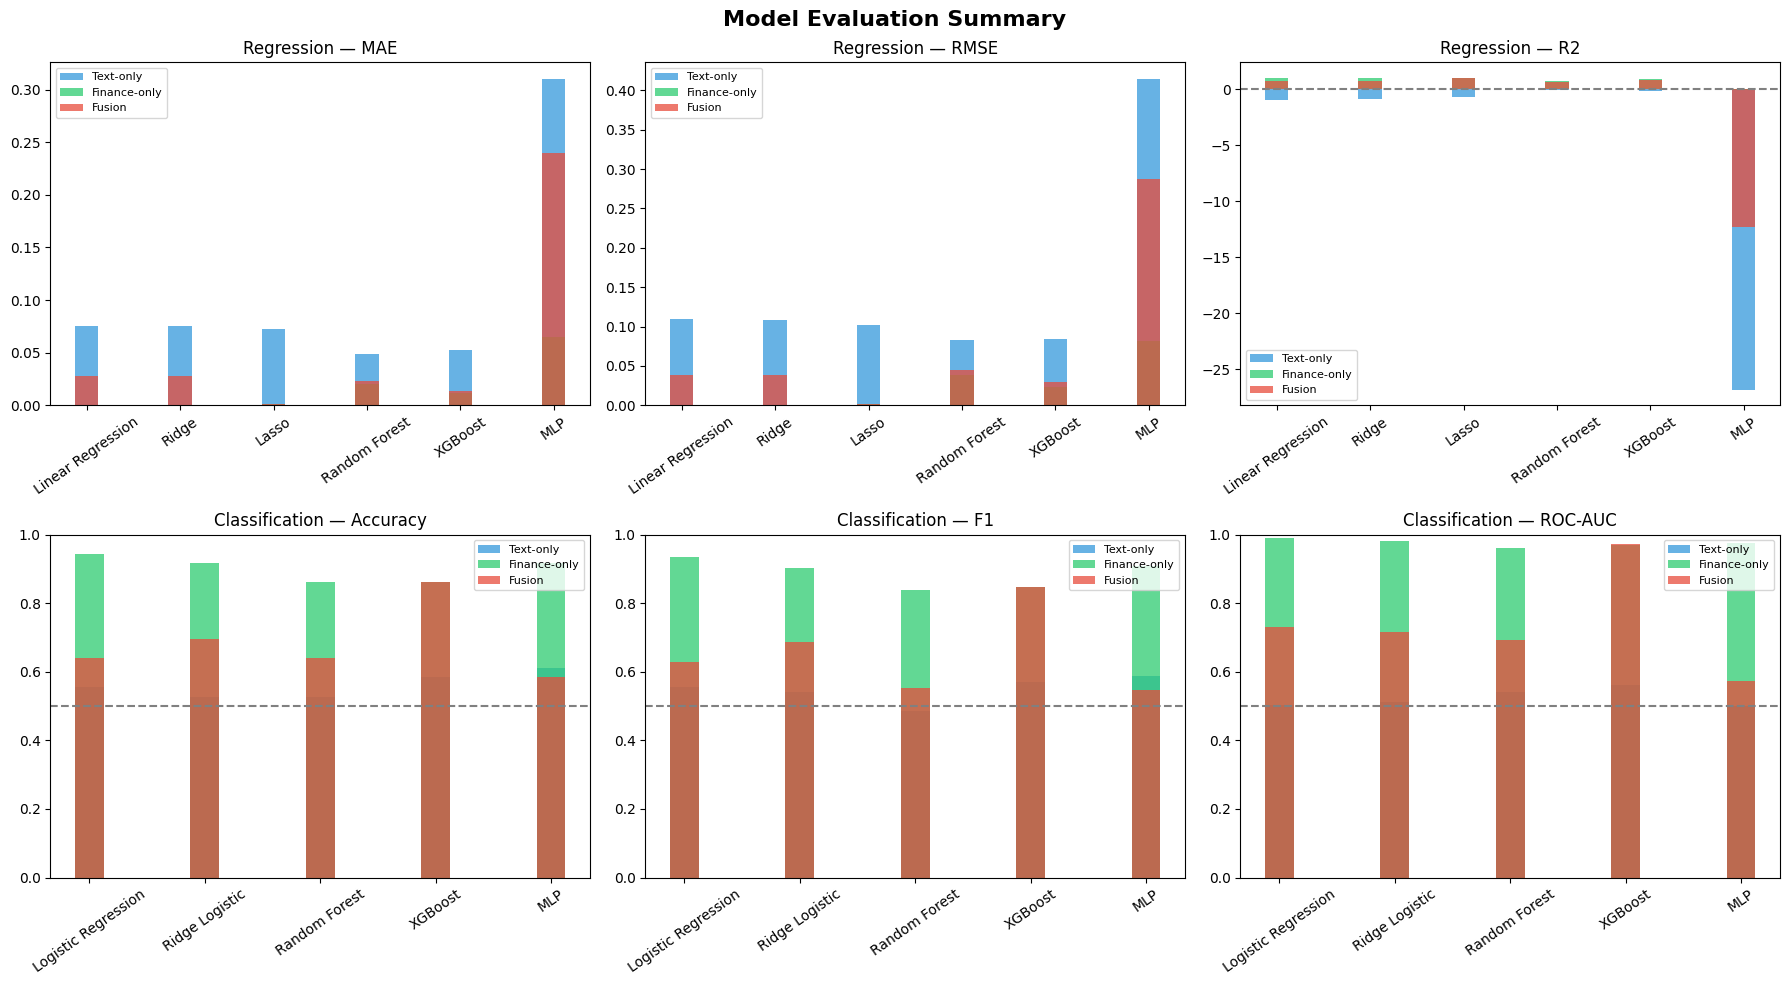

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Evaluation Summary', fontsize=16, fontweight='bold')

FEATURE_SETS  = ['Text-only', 'Finance-only', 'Fusion']
PALETTE       = {'Text-only': '#3498db', 'Finance-only': '#2ecc71', 'Fusion': '#e74c3c'}

# ── Regression ─────────────────────────────────────────────────────────────
for ax, metric in zip(axes[0], ['MAE', 'RMSE', 'R2']):
    for fs in FEATURE_SETS:
        subset = df_reg[df_reg['FeatureSet'] == fs]
        if subset.empty:
            continue
        ax.bar(subset['Model'], subset[metric], label=fs,
               alpha=0.75, color=PALETTE[fs], width=0.25,
               align='center')
    ax.set_title(f'Regression — {metric}', fontsize=12)
    ax.tick_params(axis='x', rotation=35)
    ax.legend(fontsize=8)
    if metric == 'R2':
        ax.axhline(0, color='gray', linestyle='--')

# ── Classification ─────────────────────────────────────────────────────────
for ax, metric in zip(axes[1], ['Accuracy', 'F1', 'ROC-AUC']):
    for fs in FEATURE_SETS:
        subset = df_cls[df_cls['FeatureSet'] == fs]
        if subset.empty:
            continue
        ax.bar(subset['Model'], subset[metric], label=fs,
               alpha=0.75, color=PALETTE[fs], width=0.25,
               align='center')
    ax.set_title(f'Classification — {metric}', fontsize=12)
    ax.tick_params(axis='x', rotation=35)
    ax.legend(fontsize=8)
    ax.set_ylim(0, 1)
    ax.axhline(0.5, color='gray', linestyle='--', label='Random')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 🏆 CELL 13 — Best Model Summary

In [25]:
print('=' * 60)
print('🏆  BEST MODELS SUMMARY')
print('=' * 60)

print('\n📉 Regression (↓ RMSE, ↑ R²)')
best_reg = df_reg.loc[df_reg.groupby('FeatureSet')['R2'].idxmax()]
print(best_reg[['FeatureSet','Model','MAE','RMSE','R2']].to_string(index=False))

print('\n🎯 Classification (↑ ROC-AUC)')
best_cls = df_cls.loc[df_cls.groupby('FeatureSet')['ROC-AUC'].idxmax()]
print(best_cls[['FeatureSet','Model','Accuracy','F1','ROC-AUC']].to_string(index=False))

print('\n📁 Output files:')
for fn in ['events_raw.csv', 'events_with_finance.csv', 'final_dataset.csv',
           'regression_results.csv', 'classification_results.csv',
           'car_distribution.png', 'model_comparison.png']:
    path = f'{OUTPUT_DIR}/{fn}'
    exists = '✅' if os.path.exists(path) else '❌'
    print(f'  {exists}  {path}')

🏆  BEST MODELS SUMMARY

📉 Regression (↓ RMSE, ↑ R²)
  FeatureSet             Model     MAE    RMSE      R2
Finance-only Linear Regression 0.00000 0.00000  1.0000
      Fusion             Lasso 0.00119 0.00187  0.9994
   Text-only     Random Forest 0.04915 0.08313 -0.1170

🎯 Classification (↑ ROC-AUC)
  FeatureSet               Model  Accuracy     F1  ROC-AUC
Finance-only Logistic Regression    0.9444 0.9333   0.9906
      Fusion             XGBoost    0.8611 0.8485   0.9719
   Text-only             XGBoost    0.5833 0.5714   0.5625

📁 Output files:
  ✅  E:/Prem Lehar/Scripts/CURSOR scripts/ADNI_MRI/v9_ADNI_MRI_700_Without_Resampling_3DCNN_MedicalNet/ATS_PROJECT_CODE/outputs_new_one_ats_project/events_raw.csv
  ✅  E:/Prem Lehar/Scripts/CURSOR scripts/ADNI_MRI/v9_ADNI_MRI_700_Without_Resampling_3DCNN_MedicalNet/ATS_PROJECT_CODE/outputs_new_one_ats_project/events_with_finance.csv
  ✅  E:/Prem Lehar/Scripts/CURSOR scripts/ADNI_MRI/v9_ADNI_MRI_700_Without_Resampling_3DCNN_MedicalNet/ATS_PRO

---

## 🔧 BONUS CELL — CAR Window Sensitivity Analysis

Try different CAR windows: [0,+1], [0,+2], [-1,+1] and compare performance.

In [26]:
# ── Recompute CAR with a different window ──────────────────────────────────
# Edit this to explore different windows
CAR_WINDOW = (0, 2)   # [t0, t0+2]

print(f'CAR window [{CAR_WINDOW[0]}, +{CAR_WINDOW[1]}] sensitivity check')
print('(Modify CAR_WINDOW and the compute_car function for a full re-run)')
print('Tip: For [-1,+1] use CAR = AR_{-1} + AR_0 + AR_1')

CAR window [0, +2] sensitivity check
(Modify CAR_WINDOW and the compute_car function for a full re-run)
Tip: For [-1,+1] use CAR = AR_{-1} + AR_0 + AR_1


## 🔧 BONUS CELL — Ablation: Text vs Finance vs Fusion

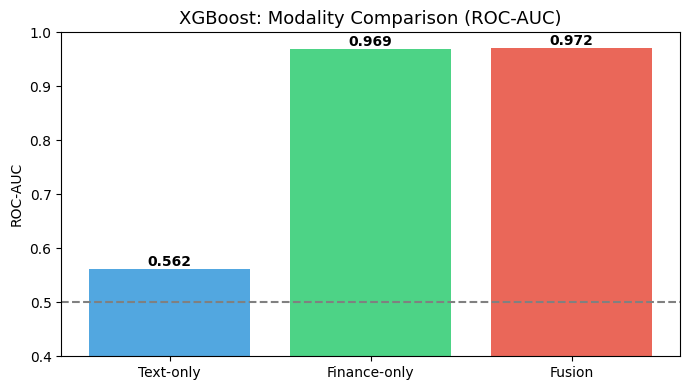

In [27]:
# Quick bar chart showing fusion lift over single modalities
if 'df_cls' in dir():
    xgb_auc = df_cls[df_cls['Model']=='XGBoost'][['FeatureSet','ROC-AUC']].set_index('FeatureSet')

    fig, ax = plt.subplots(figsize=(7,4))
    colors = ['#3498db','#2ecc71','#e74c3c']
    for (fs, row), c in zip(xgb_auc.iterrows(), colors):
        ax.bar(fs, row['ROC-AUC'], color=c, alpha=0.85)
        ax.text(fs, row['ROC-AUC']+0.005, f"{row['ROC-AUC']:.3f}", ha='center', fontweight='bold')

    ax.axhline(0.5, color='gray', linestyle='--', label='Random baseline')
    ax.set_ylabel('ROC-AUC')
    ax.set_title('XGBoost: Modality Comparison (ROC-AUC)', fontsize=13)
    ax.set_ylim(0.4, 1.0)
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/ablation_xgboost.png', dpi=150)
    plt.show()